# Annual Mean Temperature Distribution
This looks at how surface temperature develops with time throughout the year

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier, gamma_linear_approx, swdn_from_temp_fourier
from isca_tools.thesis.hottest_date import get_var_extrema_date
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc', 
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'rho', 'p_atm', 'ps', 'q_surf']  
# Load dataset
tau_lw = [1]
n_exp = len(tau_lw)
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
exp_dir = 'aquaplanet/no_wishe/'
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
# exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_no_conv" for i in range(n_exp)]
exp_name = [f"k={str(tau_lw[i]).replace('.','_')}_const_rh" for i in range(n_exp)]

# exp_dir = 'rossbypalooza/variable_evap_flux/evap=0/'
# exp_name=''

lat_range = slice(20, 90)               # only consider NH and outside deep tropics
use_time_start = 360*2
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf)).sel(lat=lat_range)]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]
w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
try: 
    rh_flux_q = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['rh_flux_q']
except KeyError:
    rh_flux_q = 0
p_surface_approx = isca_tools.load_namelist(exp_dir+exp_name[0])['spectral_dynamics_nml']['reference_sea_level_press']/100

100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

Removing height from var_keep


In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [5]:
ds = ds_base[0].sel(pfull=p_surface_approx, method='nearest')
p_surface = float(ds.pfull)*100
sigma_near_surf = float(ds.pfull/p_surface_approx)
ds['rh'] = ds.sphum / sphum_sat(ds.temp, p_surface)
ds = annual_mean(ds).mean(dim='lon')
ds = ds.assign_coords(time=(ds.time - ds.time.min()).astype(int)).load()

In [6]:
# Make every thing dependent on surface temperature (NOT NEAR-SURFACE) as equation easier to solve
# Link to near-surface with T_{s-a} term in latent flux etc
n_lat = ds.lat.size
t_surf = ds.t_surf.to_numpy().transpose()
t_surf_spline_fit = [scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
                                                       np.append(t_surf[i], t_surf[i, 0]), bc_type='periodic') for i in range(n_lat)]
# t_surf_anom_spline_fit = scipy.interpolate.CubicSpline(np.append(ds.time.to_numpy(), ds.time[-1]+1), 
#                                                        np.append(t_surf_anom, t_surf_anom[0]), bc_type='periodic')

def linear_func(x_var, a, b):
    return a + b*x_var

def square_func(x_var, a, b, c):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_squared = (x_var-np.mean(x_var))**2
    return a + b*x_var + c*(x_anom_squared - np.mean(x_anom_squared))

def quartic_func(x_var, a, b, c, d, e):
    # Subtract mean of squared anomaly so c does not influence value of a and b.
    x_anom_cubed = (x_var-np.mean(x_var))**3
    x_anom_fourth_power = (x_var-np.mean(x_var))**4
    return square_func(x_var, a, b, c) + d*(x_anom_cubed - np.mean(x_anom_cubed)) + \
        e*(x_anom_fourth_power-np.mean(x_anom_fourth_power))

def linear_func_shift(time, a, b, c, spline):
    x_var_shift = spline(time-c)
    return a + b*x_var_shift

## Latent Heat
###  RH Fitting
To get solution for temperature time-series, we need to represent relative humidity as a function of surface temperature. 
We investigate a linear fit, $r_s \propto T_s(t)$ and a linear phase fit, $r_s \propto T_s(t - \Lambda_r)$.

In [7]:
# Define error func to use
error_func_dict = {'Max': lambda x, x_approx: np.abs(x - x_approx).max(dim='time'), 
                   'Median': lambda x, x_approx: np.abs(x - x_approx).median(dim='time'), 
                   'Mean': lambda x, x_approx: np.abs(x - x_approx).mean(dim='time')}
error_func_use = 'Median'
error_func = error_func_dict[error_func_use.capitalize()]

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
plot_lat_spacing = 6
color_lat = plt.cm.jet(np.linspace(0,1,int(np.ceil(n_lat/plot_lat_spacing))))[::-1]
linestyles_approx = {'linear': ':', 'linear_shift': ':', 'square': '--', 'square_shift': '--', 'quartic': '-', 'final': '--'}
colors_approx = {'linear': 'k', 'linear_shift': 'purple', 'square': 'k', 'square_shift': 'purple', 'quartic': default_colors[3]}

### Form of `approx_params` arrays
The most general form of approximation for each surface flux is $\lambda_0 + \lambda T(t) + \lambda_{\Lambda}T(t-\Lambda) + \lambda_{sq}(T(t)^2 - \overline{T(t)^2})$.

In `approx_params`:
* `approx_params[:, 0]` $= \lambda_0$
* `approx_params[:, 1]` $= \lambda$
* `approx_params[:, 2]` $= \lambda_{\Lambda}$
* `approx_params[:, 3]` $= \Lambda$
* `approx_params[:, 4]` $= \lambda_{sq}$

(0.0, 7.95904086183302)

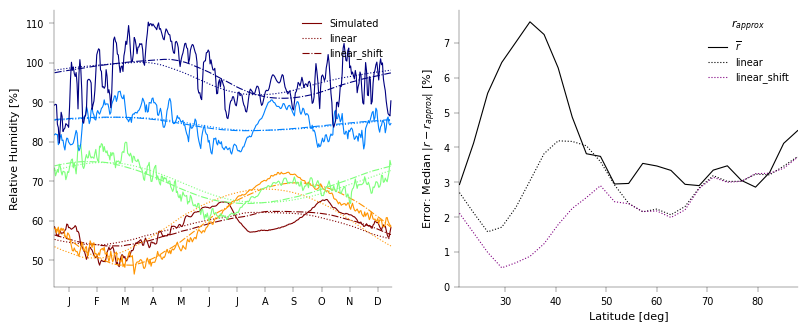

In [8]:
# In params, 0 is lambda_0, 1 is lambda, 2 is Lambda and 3 is lambda_sq
n_approx_params = 5
rh_approx_params = {'linear': np.zeros((n_lat, n_approx_params)), 'linear_shift': np.zeros((n_lat, n_approx_params))}
rh_approx = {'linear': np.zeros((n_lat, ds.time.size)), 'linear_shift': np.zeros((n_lat, ds.time.size))}
for i in range(n_lat):
    rh_approx_params['linear'][i, :2] = optimize.curve_fit(linear_func, t_surf[i], 
                                                           ds.rh[:, i]-ds.rh[:, i].mean(), p0=[0, 0])[0]
    rh_approx['linear'][i] = linear_func(t_surf[i], *rh_approx_params['linear'][i, :2]) + float(ds.rh[:, i].mean())
    fit_func_use = lambda x, a, b, c: linear_func_shift(x, a, b, c, spline=t_surf_spline_fit[i])
    rh_approx_params['linear_shift'][i, [0, 2, 3]] = optimize.curve_fit(fit_func_use, ds.time, 
                                              ds.rh[:, i]-ds.rh[:, i].mean(), p0=[0, 0, 0])[0]
    rh_approx['linear_shift'][i] = fit_func_use(ds.time, *rh_approx_params['linear_shift'][i, [0, 2, 3]]) + float(ds.rh[:, i].mean())
    
fig, ax = plt.subplots(1, 2, figsize=(1.5*2*width['one_col'], 1.5*width['one_col']/ar))
for j, i in enumerate(range(0, n_lat, plot_lat_spacing)):
    ax[0].plot(ds.time, 100*ds.rh[:, i], label='Simulated' if i==0 else None, color=color_lat[j])
    for key in rh_approx:
        ax[0].plot(ds.time, 100*rh_approx[key][i], color=color_lat[j], linestyle='-.' if 'shift' in key else linestyles_approx[key], 
                   label=key if j==0 else None)
    # ax[0].plot(ds.time, 100*rh_approx['linear_shift'][i], color=color_lat[j], linestyle=':', label='Approx: Linear + Phase' if j==0 else None)
ax[1].plot(ds.lat, error_func(ds.rh, ds.rh.mean(dim='time'))*100, color='k', label='$\overline{r}$')
for key in rh_approx:
    ax[1].plot(ds.lat, error_func(ds.rh.transpose(), rh_approx[key])*100, linestyle=linestyles_approx[key], color=colors_approx[key], label=key)
ax[0].legend()
ax[1].legend(title='$r_{approx}$')
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, 360)
ax[0].set_ylabel('Relative Humidity [%]')
ax[1].set_ylabel(f'Error: {error_func_use} '+'$|r - r_{approx}|$ [%]')
ax[1].set_xlim(ds.lat[0], ds.lat[-1])
ax[1].set_xlabel('Latitude [deg]')
ax[1].set_ylim(0, ax[1].get_ylim()[1])
# cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
# cbar.ax.invert_yaxis()
# cbar.ax.set_yticks(*month_ticks)
# fig.suptitle(f'Lat = ${int(ds.lat)}\degree$', fontsize=9, y=0.92);

### Latent Heat Decomposition: RH and Temperature components

This clearly shows importance of phasing of RH at lower latitudes, and inclusion of $\lambda_{sq}$ at high latitudes.

In [40]:
if rh_flux_q == 0:
    lh_rh_prefactor = -L_v * w_atm_const * ds.drag_q.mean(dim='time') * get_density(ds.temp.mean(dim='time'), ds.pfull*100) * \
                      sphum_sat(ds.temp.mean(dim='time'), ds.pfull*100)
else:
    lh_rh_prefactor = sphum_sat(ds.temp.mean(dim='time'), ds.pfull*100) * 0
lh_rh_cont = lh_rh_prefactor * (ds.rh - ds.rh.mean(dim='time'))
lh_rh_cont_approx_params = {key: np.zeros((n_lat, n_approx_params)) for key in rh_approx}
for key in lh_rh_cont_approx_params:
    lh_rh_cont_approx_params[key][:, 0] = lh_rh_prefactor * rh_approx_params[key][:, 0]
    lh_rh_cont_approx_params[key][:, 1] = lh_rh_prefactor * rh_approx_params[key][:, 1]
    lh_rh_cont_approx_params[key][:, 2] = lh_rh_prefactor * rh_approx_params[key][:, 2]
    lh_rh_cont_approx_params[key][:, 3] = rh_approx_params[key][:, 3]
lh_rh_cont_approx = {key: np.zeros((n_lat, ds.time.size)) for key in rh_approx}
for i in range(n_lat):
    lh_rh_cont_approx['linear'][i] = linear_func(t_surf[i], *lh_rh_cont_approx_params['linear'][i, :2])
    lh_rh_cont_approx['linear_shift'][i] = linear_func_shift(ds.time, *lh_rh_cont_approx_params['linear_shift'][i, [0, 2, 3]],
                                                             spline=t_surf_spline_fit[i])

In [41]:
param_guess = [-1000, 3, 0]         # last value is for squared fitting
lh_temp_cont = ds.flux_lhe.transpose() - lh_rh_cont
lh_temp_cont_approx_params = {key: np.zeros((n_lat, n_approx_params)) for key in ['linear', 'square']}
for i in range(n_lat):
    lh_temp_cont_approx_params['linear'][i, :2] = optimize.curve_fit(linear_func, t_surf[i], lh_temp_cont[i], p0=param_guess[:-1])[0]
    lh_temp_cont_approx_params['square'][i, [0, 1, 4]] = optimize.curve_fit(square_func, t_surf[i], lh_temp_cont[i], p0=param_guess)[0]
    
lh_temp_cont_approx = {key: np.zeros((n_lat, ds.time.size)) for key in lh_temp_cont_approx_params}
for i in range(n_lat):
    lh_temp_cont_approx['linear'][i] = linear_func(t_surf[i], *lh_temp_cont_approx_params['linear'][i, :2])
    lh_temp_cont_approx['square'][i] = square_func(t_surf[i], *lh_temp_cont_approx_params['square'][i, [0, 1, 4]])

In [42]:
lh_approx_params = {'linear': lh_rh_cont_approx_params['linear'] + lh_temp_cont_approx_params['linear'], 
                    'linear_shift': lh_rh_cont_approx_params['linear_shift'] + lh_temp_cont_approx_params['linear'], 
                    'square': lh_rh_cont_approx_params['linear'] + lh_temp_cont_approx_params['square'], 
                    'square_shift': lh_rh_cont_approx_params['linear_shift'] + lh_temp_cont_approx_params['square']}
lh_approx ={'linear': lh_rh_cont_approx['linear'] + lh_temp_cont_approx['linear'], 
            'linear_shift': lh_rh_cont_approx['linear_shift'] + lh_temp_cont_approx['linear'], 
            'square': lh_rh_cont_approx['linear'] + lh_temp_cont_approx['square'], 
            'square_shift': lh_rh_cont_approx['linear_shift'] + lh_temp_cont_approx['square']}

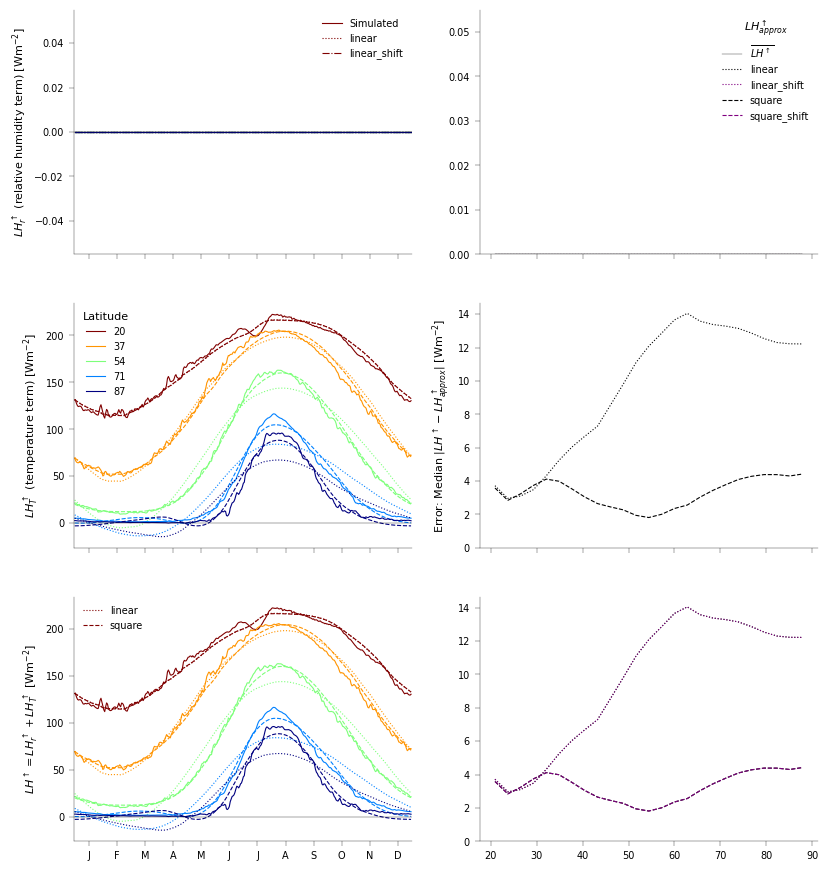

In [43]:
show_shift = False      # in bottom right show linear and square approximations. Will include shift in these two if show_shift=True
fig, ax = plt.subplots(3, 2, figsize=(1.5*2*width['one_col'], 3*1.5*width['one_col']/ar), sharex='col')
for j, i in enumerate(range(0, n_lat, plot_lat_spacing)):
    ax[0, 0].plot(ds.time, lh_rh_cont[i], label='Simulated' if i==0 else None, color=color_lat[j])
    for key in rh_approx:
        ax[0, 0].plot(ds.time, lh_rh_cont_approx[key][i], color=color_lat[j], linestyle='-.' if 'shift' in key else linestyles_approx[key], 
                      label=key if j==0 else None)
    ax[1, 0].plot(ds.time, lh_temp_cont[i], color=color_lat[j], label=int(ds.lat[i]))
    for key in lh_temp_cont_approx:
        ax[1, 0].plot(ds.time, lh_temp_cont_approx[key][i], color=color_lat[j], linestyle=linestyles_approx[key])
    ax[2, 0].plot(ds.time, ds.flux_lhe[:, i], color=color_lat[j])
    for key in [f"linear{'_shift' if show_shift else ''}", f"square{'_shift' if show_shift else ''}"]:
        ax[2, 0].plot(ds.time, lh_approx[key][i], color=color_lat[j], linestyle=linestyles_approx[key], label=key if j==0 else None)
l1, = ax[0, 1].plot(ds.lat, error_func(lh_rh_cont, lh_rh_cont.mean(dim='time')), color='k', label='$\overline{LH^{\\uparrow}}$', lw=ax_linewidth)
for key in rh_approx:
    ax[0, 1].plot(ds.lat, error_func(lh_rh_cont, lh_rh_cont_approx[key]), color=colors_approx[key], linestyle=linestyles_approx[key])
for key in lh_temp_cont_approx:
    ax[1, 1].plot(ds.lat, error_func(lh_temp_cont, lh_temp_cont_approx[key]), color=colors_approx[key], linestyle=linestyles_approx[key])
for key in lh_approx:
    ax[2, 1].plot(ds.lat, error_func(ds.flux_lhe.transpose(), lh_approx[key]), color=colors_approx[key], linestyle=linestyles_approx[key], 
                  label=key)
ax[0, 0].legend()
ax[1, 0].legend(title='Latitude')
ax[2, 0].legend()
ax[0, 1].legend(ax[0, 1].get_legend_handles_labels()[0]+ax[2, 1].get_legend_handles_labels()[0], 
                ax[0, 1].get_legend_handles_labels()[1] + ax[2, 1].get_legend_handles_labels()[1], title='$LH^{\\uparrow}_{approx}$')

ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(-1, 360)
ax[0, 0].set_ylabel('$LH^{\\uparrow}_r$ (relative humidity term) [Wm$^{-2}$]')
ax[1, 0].set_ylabel('$LH^{\\uparrow}_T$ (temperature term) [Wm$^{-2}$]')
ax[2, 0].set_ylabel('$LH^{\\uparrow} = LH^{\\uparrow}_r + LH^{\\uparrow}_T$ [Wm$^{-2}$]')
ax[1, 1].set_ylabel(f'Error: {error_func_use} '+'$|LH^{\\uparrow} - LH^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
for i in range(3):
    ax[i, 0].axhline(0, color='k', lw=ax_linewidth)
    ax[i, 1].set_ylim(0, ax[i, 1].get_ylim()[1])

## Sensible Heat

The linear approximation is always pretty good for sensible heat. Certainly, the phasing does not help at all.

In [44]:
sh_approx_params = {'linear': np.zeros((n_lat, n_approx_params)), 
                    'linear_shift': np.zeros((n_lat, n_approx_params)),
                    'square': np.zeros((n_lat, n_approx_params))}
sh_approx = {key: np.zeros((n_lat, ds.time.size)) for key in sh_approx_params}
for i in range(n_lat):
    sh_approx_params['linear'][i, :2] = optimize.curve_fit(linear_func, t_surf[i], ds.flux_t.to_numpy()[:, i], p0=param_guess[:-1])[0]
    fit_func_use = lambda x, a, b, c: linear_func_shift(x, a, b, c, spline=t_surf_spline_fit[i])
    sh_approx_params['linear_shift'][i, [0, 2, 3]] = optimize.curve_fit(fit_func_use, ds.time, ds.flux_t.to_numpy()[:, i], p0=param_guess)[0]
    sh_approx_params['square'][i, [0, 1, 4]] = optimize.curve_fit(square_func, t_surf[i], ds.flux_t.to_numpy()[:, i], p0=param_guess)[0]
    sh_approx['linear'][i] = linear_func(t_surf[i], *sh_approx_params['linear'][i, :2])
    sh_approx['linear_shift'][i] = fit_func_use(ds.time, *sh_approx_params['linear_shift'][i, [0, 2, 3]])
    sh_approx['square'][i] = square_func(t_surf[i], *sh_approx_params['square'][i, [0, 1, 4]])

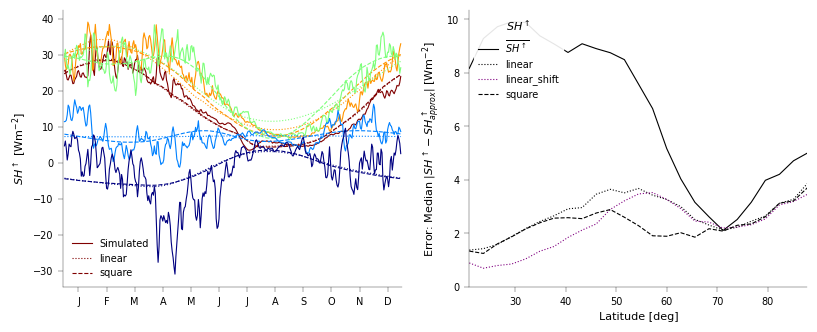

In [45]:
# show_shift = False
fig, ax = plt.subplots(1, 2, figsize=(1.5*2*width['one_col'], 1.5*width['one_col']/ar))
for j, i in enumerate(range(0, n_lat, plot_lat_spacing)):
    ax[0].plot(ds.time, ds.flux_t[:, i], label='Simulated' if i==0 else None, color=color_lat[j])
    for key in [f"linear{'_shift' if show_shift else ''}", 'square']:
        ax[0].plot(ds.time, sh_approx[key][i], color=color_lat[j], linestyle='-.' if 'shift' in key else linestyles_approx[key], 
                   label=key if j==0 else None)
    # ax[0].plot(ds.time, 100*rh_approx['linear_shift'][i], color=color_lat[j], linestyle=':', label='Approx: Linear + Phase' if j==0 else None)
ax[1].plot(ds.lat, error_func(ds.flux_t, ds.flux_t.mean(dim='time')), color='k', label='$\overline{SH^{\\uparrow}}$')
for key in sh_approx:
    ax[1].plot(ds.lat, error_func(ds.flux_t.transpose(), sh_approx[key]), linestyle=linestyles_approx[key], color=colors_approx[key], label=key)
ax[0].legend()
ax[1].legend(title='$SH^{\\uparrow}$', loc='upper left', frameon=True, framealpha=0.9, edgecolor='white')
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, 360)
ax[0].set_ylabel('$SH^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel(f'Error: {error_func_use} '+'$|SH^{\\uparrow} - SH^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[1].set_xlim(ds.lat[0], ds.lat[-1])
ax[1].set_xlabel('Latitude [deg]')
ax[1].set_ylim(0, ax[1].get_ylim()[1]);

## Longwave
When it comes to the net longwave, the squared term is fairly important at the highest latitudes, and there is a small latitude range around $50\degree$ where a phase delay is useful.

In [46]:
lw_up_approx_params = {'linear': np.zeros((n_lat, n_approx_params)), 
                       'square': np.zeros((n_lat, n_approx_params)),
                       'quartic': np.zeros((n_lat, 5))}
lw_up_approx = {key: np.zeros((n_lat, ds.time.size)) for key in lw_up_approx_params}
for i in range(n_lat):
    lw_up_approx_params['linear'][i, :2] = optimize.curve_fit(linear_func, t_surf[i], ds.lwup_sfc.to_numpy()[:, i], p0=param_guess[:-1])[0]
    lw_up_approx_params['square'][i, [0, 1, 4]] = optimize.curve_fit(square_func, t_surf[i], ds.lwup_sfc.to_numpy()[:, i], p0=param_guess)[0]
    lw_up_approx_params['quartic'][i] = optimize.curve_fit(quartic_func, t_surf[i], ds.lwup_sfc.to_numpy()[:, i], p0=param_guess+[0, 0])[0]
    lw_up_approx['linear'][i] = linear_func(t_surf[i], *lw_up_approx_params['linear'][i, :2])
    lw_up_approx['square'][i] = square_func(t_surf[i], *lw_up_approx_params['square'][i, [0, 1, 4]])
    lw_up_approx['quartic'][i] = quartic_func(t_surf[i], *lw_up_approx_params['quartic'][i])

In [47]:
lw_dn_approx_params = {'linear': np.zeros((n_lat, n_approx_params)),
                       'linear_shift': np.zeros((n_lat, n_approx_params)),
                       'square': np.zeros((n_lat, n_approx_params)),
                       'quartic': np.zeros((n_lat, 5))}
lw_dn_approx = {key: np.zeros((n_lat, ds.time.size)) for key in lw_dn_approx_params}
for i in range(n_lat):
    lw_dn_approx_params['linear'][i, :2] = optimize.curve_fit(linear_func, t_surf[i], ds.lwdn_sfc.to_numpy()[:, i], p0=param_guess[:-1])[0]
    fit_func_use = lambda x, a, b, c: linear_func_shift(x, a, b, c, spline=t_surf_spline_fit[i])
    lw_dn_approx_params['linear_shift'][i, [0, 2, 3]] = optimize.curve_fit(fit_func_use, ds.time, ds.lwdn_sfc.to_numpy()[:, i], p0=param_guess)[0]
    lw_dn_approx_params['square'][i, [0, 1, 4]] = optimize.curve_fit(square_func, t_surf[i], ds.lwdn_sfc.to_numpy()[:, i], p0=param_guess)[0]
    lw_dn_approx_params['quartic'][i] = optimize.curve_fit(quartic_func, t_surf[i], ds.lwdn_sfc.to_numpy()[:, i], p0=param_guess+[0, 0])[0]
    lw_dn_approx['linear'][i] = linear_func(t_surf[i], *lw_dn_approx_params['linear'][i, :2])
    lw_dn_approx['linear_shift'][i] = fit_func_use(ds.time, *lw_dn_approx_params['linear_shift'][i, [0, 2, 3]])
    lw_dn_approx['square'][i] = square_func(t_surf[i], *lw_dn_approx_params['square'][i, [0, 1, 4]])
    lw_dn_approx['quartic'][i] = quartic_func(t_surf[i], *lw_dn_approx_params['quartic'][i])

In [48]:
lw_net_approx_params = {'linear': lw_up_approx_params['linear'] - lw_dn_approx_params['linear'],
                        'linear_shift': lw_up_approx_params['linear'] - lw_dn_approx_params['linear_shift'],
                        'square': lw_up_approx_params['square'] - lw_dn_approx_params['square']}
lw_net_approx = {'linear': lw_up_approx['linear'] - lw_dn_approx['linear'],
                 'linear_shift': lw_up_approx['linear'] - lw_dn_approx['linear_shift'],
                 'square': lw_up_approx['square'] - lw_dn_approx['square'], 
                 'quartic': lw_up_approx['quartic'] - lw_dn_approx['quartic']}

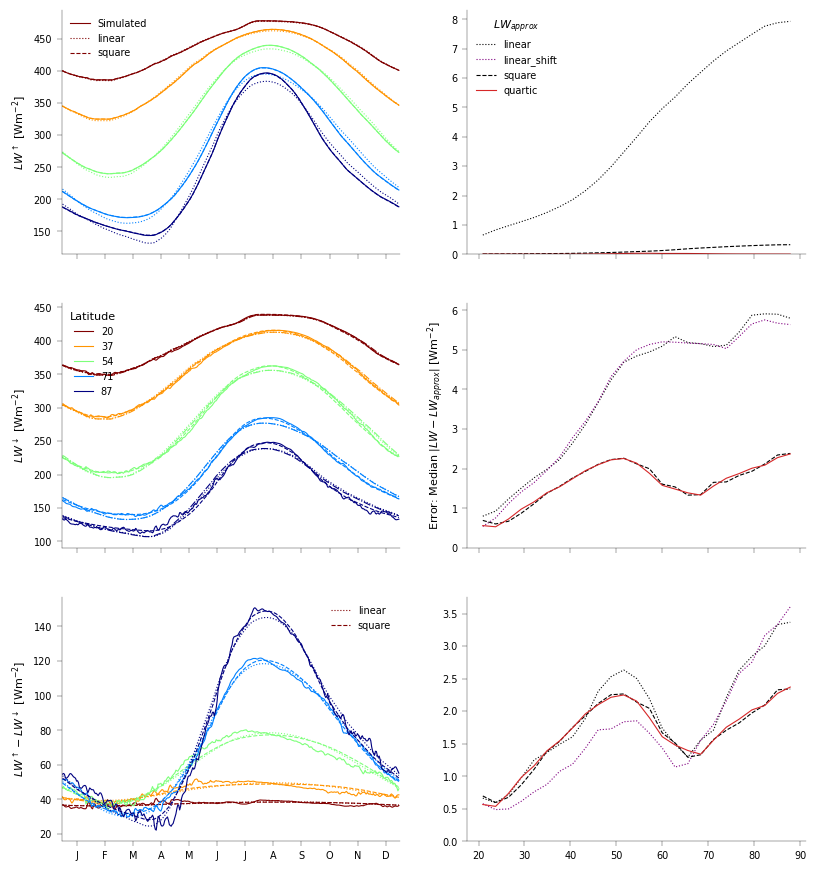

In [49]:
# show_shift = False
fig, ax = plt.subplots(3, 2, figsize=(1.5*2*width['one_col'], 3*1.5*width['one_col']/ar), sharex='col')
for j, i in enumerate(range(0, n_lat, plot_lat_spacing)):
    ax[0, 0].plot(ds.time, ds.lwup_sfc[:, i], label='Simulated' if i==0 else None, color=color_lat[j])
    for key in lw_up_approx:
        if key == 'quartic':
            continue
        ax[0, 0].plot(ds.time, lw_up_approx[key][i], color=color_lat[j], linestyle='-.' if 'shift' in key else linestyles_approx[key], 
                      label=key if j==0 else None)
    ax[1, 0].plot(ds.time, ds.lwdn_sfc[:, i], color=color_lat[j], label=int(ds.lat[i]))
    for key in lw_dn_approx:
        if key == 'quartic':
            continue
        ax[1, 0].plot(ds.time, lw_dn_approx[key][i], color=color_lat[j], linestyle='-.' if 'shift' in key else linestyles_approx[key])
    ax[2, 0].plot(ds.time, ds.lwup_sfc[:, i] - ds.lwdn_sfc[:, i], color=color_lat[j])
    for key in [f"linear{'_shift' if show_shift else ''}", 'square']:
        ax[2, 0].plot(ds.time, lw_net_approx[key][i], color=color_lat[j], linestyle=linestyles_approx[key], label=key if j==0 else None)
for key in lw_up_approx:
    ax[0, 1].plot(ds.lat, error_func(ds.lwup_sfc.transpose(), lw_up_approx[key]), color=colors_approx[key], linestyle=linestyles_approx[key])
for key in lw_dn_approx:
    ax[1, 1].plot(ds.lat, error_func(ds.lwdn_sfc.transpose(), lw_dn_approx[key]), color=colors_approx[key], linestyle=linestyles_approx[key])
for key in lw_net_approx:
    ax[2, 1].plot(ds.lat, error_func((ds.lwup_sfc - ds.lwdn_sfc).transpose(), lw_net_approx[key]), 
                  color=colors_approx[key], linestyle=linestyles_approx[key], label=key)
ax[0, 0].legend()
ax[1, 0].legend(title='Latitude')
ax[2, 0].legend()
ax[0, 1].legend(ax[0, 1].get_legend_handles_labels()[0]+ax[2, 1].get_legend_handles_labels()[0], 
                ax[0, 1].get_legend_handles_labels()[1] + ax[2, 1].get_legend_handles_labels()[1], title='$LW_{approx}$')

ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_xlim(-1, 360)
ax[0, 0].set_ylabel('$LW^{\\uparrow}$ [Wm$^{-2}$]')
ax[1, 0].set_ylabel('$LW^{\\downarrow}$ [Wm$^{-2}$]')
ax[2, 0].set_ylabel('$LW^{\\uparrow} - LW^{\\downarrow}$ [Wm$^{-2}$]')
ax[1, 1].set_ylabel(f'Error: {error_func_use} '+'$|LW - LW_{approx}|$ [Wm$^{-2}$]')
for i in range(3):
    ax[i, 1].set_ylim(0, ax[i, 1].get_ylim()[1])
#     ax[i, 0].axhline(0, color='k', lw=ax_linewidth)
     

## $\Gamma^{\uparrow}$ Approximation

Below we see that the phase relation for the relative humidity contribution of latent heat is important at low latitudes, and the squared component of latent heat is important at high latitudes.

In [50]:
gamma = (ds.lwup_sfc - ds.lwdn_sfc + ds.flux_lhe + ds.flux_t).transpose()
gamma_approx_params = {key: lw_net_approx_params['linear' if 'lw1' in key else 'square'] + 
                            lh_approx_params[('linear' if 'lh1' in key else 'square') + ('_shift' if 'shift' in key else '')] + 
                            sh_approx_params['square' if 'sh2' in key else 'linear']
                       for key in ['lw1_lh1', 'lw1_lh2', 'lw2_lh1', 'lw2_lh2', 'lw1_lh1_shift', 'lw1_lh2_shift', 'lw2_lh2_shift', 
                                   'lw2_lh2_shift_sh2']}
gamma_approx = {key: lw_net_approx['linear' if 'lw1' in key else 'square'] + 
                     lh_approx[('linear' if 'lh1' in key else 'square') + ('_shift' if 'shift' in key else '')] + 
                     sh_approx['square' if 'sh2' in key else 'linear'] 
                for key in gamma_approx_params}
gamma_approx['lw4_lh2_shift_sh2'] = lw_net_approx['quartic'] + lh_approx['square_shift'] + sh_approx['square']

gamma_approx_params['quartic'] = np.zeros((n_lat, 5))
gamma_approx['quartic'] = np.zeros((n_lat, ds.time.size))
for i in range(n_lat):
    gamma_approx_params['quartic'][i] = optimize.curve_fit(quartic_func, t_surf[i], gamma[i].to_numpy(), p0=param_guess+[0, 0])[0]
    gamma_approx['quartic'][i] = quartic_func(t_surf[i], *gamma_approx_params['quartic'][i])

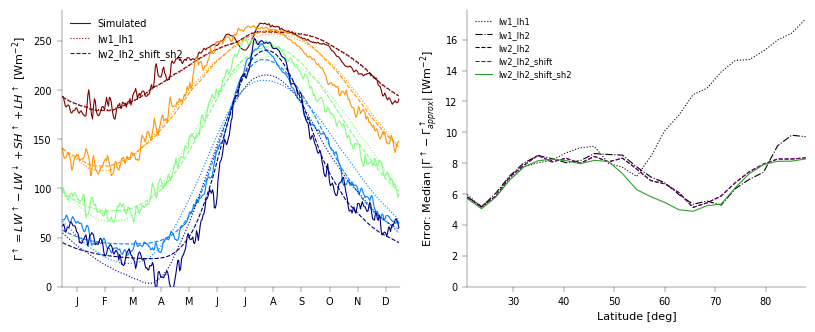

In [51]:
save_gamma_approx_fig = False
keys_plot = ['lw1_lh1', 'lw1_lh2', 'lw2_lh2', 'lw2_lh2_shift', 'lw2_lh2_shift_sh2']
colors_gamma = {'lw1_lh1': colors_approx['linear'], 'lw2_lh2': colors_approx['square'], 
                'lw1_lh1_shift': colors_approx['linear_shift'], 'lw2_lh2_shift': colors_approx['square_shift'], 
                'lw1_lh2': colors_approx['linear'], 'lw1_lh2_shift': colors_approx['linear_shift'], 'lw2_lh1': default_colors[1], 
                'lw2_lh2_shift_sh2': default_colors[2], 'lw4_lh2_shift_sh2': colors_approx['quartic']}
linestyles_gamma = {'lw1_lh1': linestyles_approx['linear'], 'lw2_lh2': linestyles_approx['square'], 
                    'lw1_lh1_shift': linestyles_approx['linear_shift'], 'lw2_lh2_shift': linestyles_approx['square_shift'], 
                    'lw1_lh2': '-.', 'lw1_lh2_shift': '-.', 'lw2_lh1': '-.', 
                    'lw2_lh2_shift_sh2': linestyles_approx['quartic'], 'lw4_lh2_shift_sh2': linestyles_approx['quartic']}
fig, ax = plt.subplots(1, 2, figsize=(1.5*2*width['one_col'], 1.5*width['one_col']/ar))
for j, i in enumerate(range(0, n_lat, plot_lat_spacing)):
    ax[0].plot(ds.time, gamma[i], label='Simulated' if j==0 else None, color=color_lat[j])
    for key in ['lw1_lh1', 'lw2_lh2_shift_sh2']:
        ax[0].plot(ds.time, gamma_approx[key][i], color=color_lat[j], linestyle=':' if key=='lw1_lh1' else '--', 
                   label=key if j==0 else None)
#     # ax[0].plot(ds.time, 100*rh_approx['linear_shift'][i], color=color_lat[j], linestyle=':', label='Approx: Linear + Phase' if j==0 else None)
# ax[1].plot(ds.lat, error_func(ds.flux_t, ds.flux_t.mean(dim='time')), color='k', label='$\overline{SH^{\\uparrow}}$')
for key in keys_plot:
    ax[1].plot(ds.lat, error_func(gamma, gamma_approx[key]), linestyle=linestyles_gamma[key], color=colors_gamma[key], label=key)
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, 360)
ax[0].legend()
ax[1].legend(fontsize=6)
ax[0].set_ylabel('$\Gamma^{\\uparrow} = LW^{\\uparrow} - LW^{\\downarrow} + SH^{\\uparrow} + LH^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel(f'Error: {error_func_use} '+'$|\Gamma^{\\uparrow} - \Gamma^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[1].set_xlim(ds.lat[0], ds.lat[-1])
ax[1].set_xlabel('Latitude [deg]')
ax[1].set_ylim(0, ax[1].get_ylim()[1])
ax[0].set_ylim(0, ax[0].get_ylim()[1])
if save_gamma_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma_approx_{error_func_use.lower()}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Final $\Gamma^{\uparrow}$ Approximation

As the final approximation, we start with the linear approximation, and add non-zero $\Lambda_r$ to account for the phasing of relative humidity in latent heat whenever it gives an improvement of $1Wm^{-2}$ in the *Max* and *Median* error metrics.

We then do the same with $\lambda_{sq}$, we include a non-zero value to account for squared term in temperature component of latent heat whenever it gives the $1Wm^{-2}$ improvement.

The markers are included to indicate the latitudes where each approximation is used.

I include a quartic approximation, as a guide to how good we are doing (i.e. this is best we could possibly do with no phase delay). It is interesting that accounting for the phase delay at some latitudes actually does better than the quartic term.

In [53]:
def true_cluster_ind(bool_array):
    # Returns indices of clusters of neighbouring True values, and size of each cluster
    true_ranges = np.argwhere(np.diff(bool_array,prepend=False,append=False))
    true_ranges = true_ranges.reshape(len(true_ranges)//2,2)
    true_ranges = [np.arange(r[0], r[1]) for r in true_ranges]
    cluster_size = np.asarray([len(true_ranges[i]) for i in range(len(true_ranges))])
    return true_ranges, cluster_size

error_thresh = 1            # Need non-linear effect to be better than linear fit by more than 1W/m^2 in both median and max error
min_cluster_size = 4        # Need non-linear effect to be beneficial over lat range of 4 or more values to keep
ind_gamma_shift = np.logical_or(*[error_func_dict[key](gamma, gamma_approx['lw1_lh1']) - 
                                  error_func_dict[key](gamma, gamma_approx['lw1_lh1_shift']) > error_thresh for key in ['Median', 'Max']])
ind_gamma_shift, cluster_size = true_cluster_ind(ind_gamma_shift)
if len(ind_gamma_shift) > 0:
    ind_gamma_shift = np.concatenate([ind_gamma_shift[i] for i in np.argwhere(cluster_size>=min_cluster_size).flatten()])

ind_gamma_square = np.logical_or(*[error_func_dict[key](gamma, gamma_approx['lw1_lh1']) - 
                                   error_func_dict[key](gamma, gamma_approx['lw1_lh2']) > error_thresh for key in ['Median', 'Max']])
ind_gamma_square, cluster_size = true_cluster_ind(ind_gamma_square)
ind_gamma_square = np.concatenate([ind_gamma_square[i] for i in np.argwhere(cluster_size>=min_cluster_size).flatten()])

# Get final gamma approx
gamma_approx_params['final'] = copy.deepcopy(gamma_approx_params['lw1_lh1'])
gamma_approx_params['final'][ind_gamma_shift] = gamma_approx_params['lw1_lh1_shift'][ind_gamma_shift]
gamma_approx_params['final'][ind_gamma_square] = gamma_approx_params['lw1_lh2'][ind_gamma_square]

gamma_approx['final'] = copy.deepcopy(gamma_approx['lw1_lh1'])
gamma_approx['final'][ind_gamma_shift] = gamma_approx['lw1_lh1_shift'][ind_gamma_shift]
gamma_approx['final'][ind_gamma_square] = gamma_approx['lw1_lh2'][ind_gamma_square]

In [54]:
# error_func_use = 'Median'
# # error_func_use = 'Max'
# error_func = error_func_dict[error_func_use]

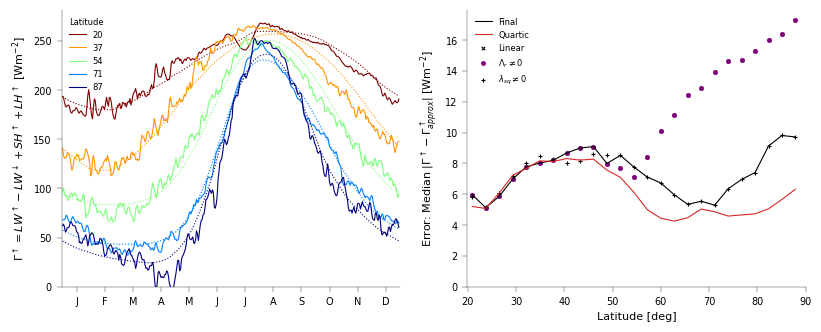

In [55]:
save_gamma_approx_final_fig = False
fig, ax = plt.subplots(1, 2, figsize=(1.5*2*width['one_col'], 1.5*width['one_col']/ar))
for j, i in enumerate(range(0, n_lat, plot_lat_spacing)):
    ax[0].plot(ds.time, gamma[i], label=int(ds.lat[i]), color=color_lat[j])
    ax[0].plot(ds.time, gamma_approx['final'][i], color=color_lat[j], linestyle=':')
#     # ax[0].plot(ds.time, 100*rh_approx['linear_shift'][i], color=color_lat[j], linestyle=':', label='Approx: Linear + Phase' if j==0 else None)
# ax[1].plot(ds.lat, error_func(ds.flux_t, ds.flux_t.mean(dim='time')), color='k', label='$\overline{SH^{\\uparrow}}$')
ax[1].plot(ds.lat, error_func(gamma, gamma_approx['final']), color='k', label='Final')
ax[1].plot(ds.lat, error_func(gamma, gamma_approx['quartic']), color=colors_approx['quartic'], label='Quartic')
ax[1].scatter(ds.lat, error_func(gamma, gamma_approx['lw1_lh1']), color=colors_approx['linear'], marker='x', label='Linear')
ax[1].scatter(ds.lat, error_func(gamma, gamma_approx['lw1_lh1_shift']), color=colors_approx['linear_shift'], label='$\Lambda_r \\neq 0$')
ax[1].scatter(ds.lat, error_func(gamma, gamma_approx['lw1_lh2']), color=colors_approx['square'], marker='+', label='$\lambda_{sq} \\neq 0$')

ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, 360)
ax[0].legend(title='Latitude', fontsize=6, title_fontsize=6)
ax[1].legend(fontsize=6)
ax[0].set_ylabel('$\Gamma^{\\uparrow} = LW^{\\uparrow} - LW^{\\downarrow} + SH^{\\uparrow} + LH^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_ylabel(f'Error: {error_func_use} '+'$|\Gamma^{\\uparrow} - \Gamma^{\\uparrow}_{approx}|$ [Wm$^{-2}$]')
ax[1].set_xlim(ds.lat[0]-1, 90)
ax[1].set_xlabel('Latitude [deg]')
ax[1].set_ylim(0, ax[1].get_ylim()[1])
ax[0].set_ylim(0, ax[0].get_ylim()[1])
if save_gamma_approx_final_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma_approx_final_{error_func_use.lower()}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Variation of parameters with latitude

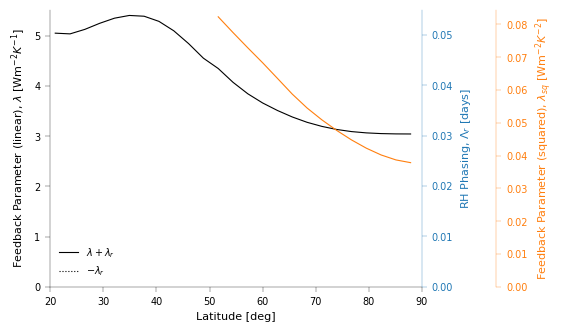

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(1.5*width['one_col'], 1.5*width['one_col']/ar))
ax = [ax, ax.twinx(), ax.twinx()]
ax[2].spines.right.set_position(("axes", 1.2))

ax[0].plot(ds.lat, gamma_approx_params['final'][:, 1]+gamma_approx_params['final'][:, 2], color='k', label='$\lambda + \lambda_r$')
ax[0].plot(ds.lat[ind_gamma_shift], -gamma_approx_params['final'][ind_gamma_shift, 2], color='k', linestyle=':', label='$-\lambda_r$')
ax[1].plot(ds.lat[ind_gamma_shift], gamma_approx_params['final'][ind_gamma_shift, 3], color=default_colors[0])
ax[2].plot(ds.lat[ind_gamma_square], gamma_approx_params['final'][ind_gamma_square, 4], color=default_colors[1])

for i in range(len(ax)):
    ax[i].set_ylim(0, ax[i].get_ylim()[1])
    if i==0: continue
    ax[i].spines[['bottom', 'left']].set_visible(False)
    ax[i].spines[['right']].set_visible(True)
    ax[i].spines.right.set_color(default_colors[i-1])
    ax[i].tick_params(axis='y', colors=default_colors[i-1])
    
ax[0].legend(loc='lower left')
ax[0].set_xlim(ds.lat[0]-1, 90)
ax[0].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Feedback Parameter (linear), $\lambda$ [Wm$^{-2}K^{-1}$]')
ax[1].set_ylabel('RH Phasing, $\Lambda_r$ [days]', color=default_colors[0])
ax[2].set_ylabel('Feedback Parameter (squared), $\lambda_{sq}$ [Wm$^{-2}K^{-2}$]', color=default_colors[1]);

## Analytic Solution for Temperature
Now we investigate the error in the analytic solution for temperature, given this $\Gamma$. We look at the error averaged across all times, as well as the error in the phase/amplitude of the hottest and coldest days.

In [59]:
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth[0])
quartic_n_harmonics = 5         # how many harmonics to fit for quartic approximation (ground truth, indicating best possible)
temp_approx = {key: np.zeros((n_lat, ds.time.size)) for key in ['final', 'linear', 'lw1_lh1_shift', 'lw1_lh2', 'quartic']}
temp_approx_fourier_amp = {key: np.zeros((n_lat, 3)) for key in temp_approx}
temp_approx_fourier_phase = {key: np.zeros((n_lat, 2)) for key in temp_approx}
sw_approx_fourier_amp = np.zeros((n_lat, 3))
for i in tqdm(range(n_lat)):
    for key in temp_approx:
        if key == 'linear':
            key_param = 'lw1_lh1'
        else:
            key_param = key
        if key_param == 'quartic':
            temp_approx[key][i] = \
                get_temp_fourier(ds.time, fourier.fourier_series(ds.time, ds.time.size, sw_approx_fourier_amp[i], [0, 0]), 
                                 heat_capacity, gamma_approx_params[key_param][i, :2], 
                                 lambda_nl=gamma_approx_params[key_param][i, 2:], numerical=True, n_harmonics=quartic_n_harmonics)[0]
        else:
            temp_approx[key][i], temp_approx_fourier_amp[key][i], temp_approx_fourier_phase[key][i], sw_approx_fourier_amp[i], _ = \
                get_temp_fourier(ds.time, ds.swdn_sfc[:, i], heat_capacity, gamma_approx_params[key_param][i, :3], 
                                 np.asarray([0, gamma_approx_params[key_param][i, 3]]), 
                                 gamma_approx_params[key_param][i, 4], single_harmonic_nl=True)

  0%|          | 0/25 [00:00<?, ?it/s]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/fourier.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  phase_coef = np.arctan(sin_coef/cos_coef)
100%|██████████| 25/25 [00:14<00:00,  1.78it/s]


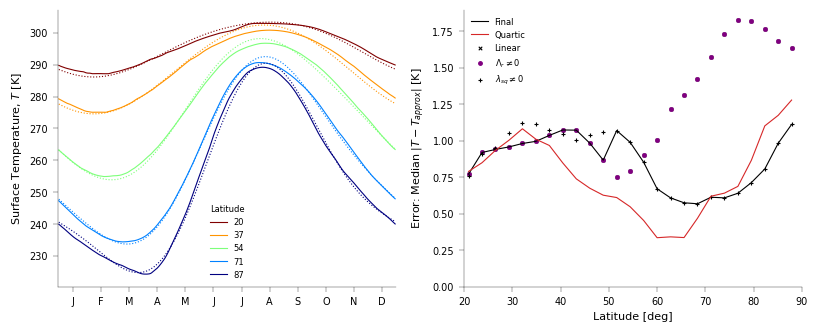

In [60]:
save_temp_approx_final_fig = False
fig, ax = plt.subplots(1, 2, figsize=(1.5*2*width['one_col'], 1.5*width['one_col']/ar))
for j, i in enumerate(range(0, n_lat, plot_lat_spacing)):
    ax[0].plot(ds.time, ds.t_surf[:, i], label=int(ds.lat[i]), color=color_lat[j])
    ax[0].plot(ds.time, temp_approx['final'][i], color=color_lat[j], linestyle=':')
#     # ax[0].plot(ds.time, 100*rh_approx['linear_shift'][i], color=color_lat[j], linestyle=':', label='Approx: Linear + Phase' if j==0 else None)
# ax[1].plot(ds.lat, error_func(ds.flux_t, ds.flux_t.mean(dim='time')), color='k', label='$\overline{SH^{\\uparrow}}$')
ax[1].plot(ds.lat, error_func(ds.t_surf.transpose(), temp_approx['final']), color='k', label='Final')
ax[1].plot(ds.lat, error_func(ds.t_surf.transpose(), temp_approx['quartic']), color=colors_approx['quartic'], label='Quartic')
ax[1].scatter(ds.lat, error_func(ds.t_surf.transpose(), temp_approx['linear']), color=colors_approx['linear'], marker='x', label='Linear')
ax[1].scatter(ds.lat, error_func(ds.t_surf.transpose(), temp_approx['lw1_lh1_shift']), color=colors_approx['linear_shift'], 
              label='$\Lambda_r \\neq 0$')
ax[1].scatter(ds.lat, error_func(ds.t_surf.transpose(), temp_approx['lw1_lh2']), color=colors_approx['square'], marker='+', 
              label='$\lambda_{sq} \\neq 0$')

ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, 360)
ax[0].legend(title='Latitude', fontsize=6, title_fontsize=6)
ax[1].legend(fontsize=6)
ax[0].set_ylabel('Surface Temperature, $T$ [K]')
ax[1].set_ylabel(f'Error: {error_func_use} '+'$|T - T_{approx}|$ [K]')
ax[1].set_xlim(ds.lat[0]-1, 90)
ax[1].set_xlabel('Latitude [deg]')
ax[1].set_ylim(0, ax[1].get_ylim()[1])
# ax[0].set_ylim(0, ax[0].get_ylim()[1])
if save_temp_approx_final_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_approx_final_{error_func_use.lower()}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [61]:
spline_spacing_date = 20        # how much smoothing to do when determining extrema dates
extrema_date = {'max': np.zeros(n_lat), 'min': np.zeros(n_lat)}
extrema_date_approx = {key: {'max': np.zeros(n_lat), 'min': np.zeros(n_lat)} for key in temp_approx}
for i in range(n_lat):
    for key in extrema_date:
        # Find only 1 extrema - will be problematic in tropics, but this is not valid there
        extrema_date[key][i] = get_var_extrema_date(ds.time, ds.t_surf[:, i], spline_spacing_date, type=key, max_extrema=1, 
                                                    thresh_extrema=float(ds.t_surf[:, i].mean()))[0][0]
        for key2 in temp_approx:
            extrema_date_approx[key2][key][i] = get_var_extrema_date(ds.time, temp_approx[key2][i], 1, type=key, max_extrema=1, 
                                                                     thresh_extrema=float(temp_approx[key2][i].mean()))[0][0]

Text(0, 0.5, 'Simulated - Approx [days]')

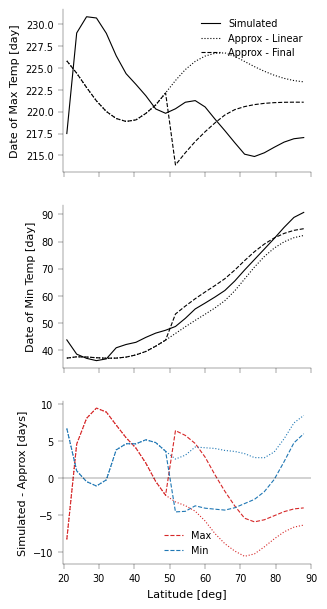

In [62]:
colors_extrema = {'max': default_colors[3], 'min': default_colors[0]}
fig, ax = plt.subplots(3, 1, figsize=(1*width['one_col'], 1*3*width['one_col']/ar), sharex=True)
for i, key in enumerate(extrema_date):
    ax[i].plot(ds.lat, extrema_date[key], color='k', label='Simulated')
    ax[i].set_ylabel(f'Date of {key.capitalize()} Temp [day]')
    for key2 in ['linear', 'final']:
        ax[i].plot(ds.lat, extrema_date_approx[key2][key], color='k', label=f'Approx - {key2.capitalize()}', linestyle=linestyles_approx[key2])
        ax[2].plot(ds.lat, extrema_date[key] - extrema_date_approx[key2][key], color=colors_extrema[key], 
                   label=key.capitalize() if key2=='final' else None, linestyle=linestyles_approx[key2])        
ax[2].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[2].legend()
ax[0].set_xlim(ds.lat[0]-1, 90)
ax[2].set_xlabel('Latitude [deg]')
ax[2].set_ylabel('Simulated - Approx [days]')

Text(0, 0.5, 'Simulated - Approx [K]')

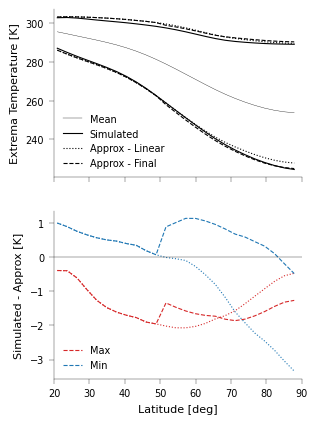

In [63]:
func_use = {'max': lambda x: np.max(x, axis=0), 'min': lambda x: np.min(x, axis=0)}
fig, ax = plt.subplots(2, 1, figsize=(1*width['one_col'], 1*2*width['one_col']/ar), sharex=True)
ax[0].plot(ds.lat, ds.t_surf.mean(dim='time'), color='k', lw=ax_linewidth, label='Mean')
for key in func_use:
    ax[0].plot(ds.lat, func_use[key](ds.t_surf), color='k', label='Simulated' if key=='max' else None)
    for key2 in ['linear', 'final']:
        ax[0].plot(ds.lat, func_use[key](temp_approx[key2].transpose()), color='k', linestyle=linestyles_approx[key2], 
                   label=f'Approx - {key2.capitalize()}' if key=='max' else None)
        ax[1].plot(ds.lat, func_use[key](ds.t_surf) - func_use[key](temp_approx[key2].transpose()), 
                color=colors_extrema[key], linestyle=linestyles_approx[key2], 
                label=key.capitalize() if key2=='final' else None)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(ds.lat[0]-1, 90)
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Extrema Temperature [K]')
ax[1].set_ylabel('Simulated - Approx [K]')